# Spatial Blog Coarse Draft

Social Sciences are increasingly using data produced by the natural sciences, which often comes in gridded formats at high spatial and temporal resolution. Data on Social outcomes is, on the other hand, often reported at adimistrative level (e.g. census tract, country, state, country), and possibly at a coarser time frequency. Combining these datasets requires therefore both spatially and temporal aggregation. 

In this blog post we will provide an example of how this can be done using the National Water Model (NWM).




### Temporal Aggregation

The NWM contains raster data on surface water depth reported at a 3 hour interval. Social and Economic data will most likely not be reported at such granular level. Therefore the first step is to create a meaningfull temporal aggregation of the NWM data.

One such aggregation is to count, for every pixel, the number of times the surface water level exceeds a certain threshold within a given period. The threshold could be specified as for example the mean or a specific quantile of the values throughout the period of study. [Talk about reasoning behind the measure?] The given period on the other hand, will have to match that of the Economic data.

In practice we can achieve this using the Xarray package as following:


Lets start by opening up all the data sets for a given day, in this case 2011/04/28, and combining them into a single dataset. The Xarray function open_mfdataset let us do this process seamlesly through one line of code. 

In [1]:
import s3fs
import xarray as xr
import re

fs = s3fs.S3FileSystem(anon=True)
nwm_path = r"noaa-nwm-retro-v2.0-pds/full_physics/2011/"
files_list = fs.ls(str(nwm_path))
filter = re.compile('.*20110428' + '.*\.RTOUT_DOMAIN1.comp')
files_filtered = [ s for s in files_list if filter.match(s) ]
#print(files_filtered)
#d = xr.open_mfdataset([ fs.open(s) for s in files_filtered])
d = xr.open_dataset(fs.open(files_filtered[0]))
print(d)


['noaa-nwm-retro-v2.0-pds/full_physics/2011/201104280000.RTOUT_DOMAIN1.comp', 'noaa-nwm-retro-v2.0-pds/full_physics/2011/201104280300.RTOUT_DOMAIN1.comp', 'noaa-nwm-retro-v2.0-pds/full_physics/2011/201104280600.RTOUT_DOMAIN1.comp', 'noaa-nwm-retro-v2.0-pds/full_physics/2011/201104280900.RTOUT_DOMAIN1.comp', 'noaa-nwm-retro-v2.0-pds/full_physics/2011/201104281200.RTOUT_DOMAIN1.comp', 'noaa-nwm-retro-v2.0-pds/full_physics/2011/201104281500.RTOUT_DOMAIN1.comp', 'noaa-nwm-retro-v2.0-pds/full_physics/2011/201104281800.RTOUT_DOMAIN1.comp', 'noaa-nwm-retro-v2.0-pds/full_physics/2011/201104282100.RTOUT_DOMAIN1.comp']


C:\ProgramData\Anaconda3\envs\nwm39\lib\site-packages\pyproj\__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


<xarray.Dataset>
Dimensions:         (time: 1, reference_time: 1, x: 18432, y: 15360)
Coordinates:
  * time            (time) datetime64[ns] 2011-04-28
  * reference_time  (reference_time) datetime64[ns] 2011-04-01
  * x               (x) float64 -2.304e+06 -2.304e+06 ... 2.304e+06 2.304e+06
  * y               (y) float64 -1.92e+06 -1.92e+06 ... 1.92e+06 1.92e+06
Data variables:
    crs             |S1 ...
    zwattablrt      (time, y, x) float64 ...
    sfcheadsubrt    (time, y, x) float64 ...
Attributes:
    model_initialization_time:  2011-04-01_00:00:00
    model_output_valid_time:    2011-04-28_00:00:00
    model_total_valid_times:    [2184]
    Conventions:                CF-1.6
    code_version:               v5.1.0-alpha11
    model_output_type:          terrain_rt
    model_configuration:        retrospective
    proj4:                      +proj=lcc +units=m +a=6370000.0 +b=6370000.0 ...
    GDAL_DataType:              Generic


We see the metadata of the xarray dataset. The data is quite large, with dimensions 18,432x15,360. We will want to subset this to our area of interest before we try to run any operations on it. We also see that the x and y coordinates are projection coordinates with units in meters. We will need to reproject these coordinates if we want to match with data in latitude-longitude coordinates.


We first read in the shapefile for Arkansas census tracts using geopandas.

In [2]:
import geopandas as gpd

# read in shapefile
state=5
statenum = str(state).zfill(2)

stfile = "C:/Users/Tim/Data/shapefiles/cb_2018_" + statenum + "_tract_500k.shp"

ar_shp=gpd.read_file(stfile)
#print(ar_shp.head())

# keep a version of the original data
orig=gpd.read_file(stfile)

import pyproj
from pyproj import Proj, transform
import dask

# get projection info
proj = d.attrs['proj4']
p=Proj(proj)


# transform lat lon coordinates to the xarray projection
from shapely.ops import transform
project = pyproj.Transformer.from_proj(
    pyproj.Proj(init='epsg:4326'), # source coordinate system
    p) # destination coordinate system

outpoly = [transform(project.transform, x) for x in ar_shp['geometry']]
ar_shp['geometry']=outpoly


# get bounding box of shapefile
bounds=ar_shp.total_bounds
#print(bounds)
minx=bounds[0]
miny=bounds[1]
maxx=bounds[2]
maxy=bounds[3]

# subset the xarray dataset based on the bounding coordinates of the state
d_ar=d.sel(x=slice(minx,maxx))
d_ar=d_ar.sel(y=slice(miny,maxy))

var = 'sfcheadsubrt'

dask.config.set(**{'array.slicing.split_large_chunks': False})

print(d_ar)


C:\ProgramData\Anaconda3\envs\nwm39\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<xarray.Dataset>
Dimensions:         (time: 1, reference_time: 1, x: 1759, y: 1602)
Coordinates:
  * time            (time) datetime64[ns] 2011-04-28
  * reference_time  (reference_time) datetime64[ns] 2011-04-01
  * x               (x) float64 2.081e+05 2.084e+05 ... 6.474e+05 6.476e+05
  * y               (y) float64 -7.539e+05 -7.536e+05 ... -3.539e+05 -3.536e+05
Data variables:
    crs             |S1 ...
    zwattablrt      (time, y, x) float64 ...
    sfcheadsubrt    (time, y, x) float64 ...
Attributes:
    model_initialization_time:  2011-04-01_00:00:00
    model_output_valid_time:    2011-04-28_00:00:00
    model_total_valid_times:    [2184]
    Conventions:                CF-1.6
    code_version:               v5.1.0-alpha11
    model_output_type:          terrain_rt
    model_configuration:        retrospective
    proj4:                      +proj=lcc +units=m +a=6370000.0 +b=6370000.0 ...
    GDAL_DataType:              Generic


Again we print the xarray metadata. Now we have data that only covers Arkansas, a grid of 1759x1602, which is much more manageable. However, since we reprojected the shapefile, our gridded data is still in projection coordinates.

#### Spatial Aggregation

Now that our data is a more manageable size, we can reproject the gridded data from projection coordinates to latitude-longitude coordinates.


In [4]:
import rioxarray
import salem
import matplotlib.pyplot as plt
import numpy as np
#import xesmf as xe





# read the crs
proj = d.attrs['proj4']
# use the format needed for salem
p=Proj(proj)

# write the crs to the xarray dataset
d_ar.rio.write_crs(proj,inplace=True)
# use rioxarray to reproject
dll = d_ar.rio.reproject("+proj=longlat +datum=WGS84 +no_defs",dtype=np.int32)


Next, we will aggregate the data up to the census tract level. Now that our data is in lat-lon coordinates, it will match up with the original shapefile data.

In [8]:
# uses salem to create a grid of points corresponding to the xarray data
# this will be needed for the aggregation
def createGrid(da,crs):
    x0=np.min(da.coords['x'])
    y0=np.max(da.coords['y'])
    # determine number of grid points
    nx=len(da.coords['x'])
    ny=len(da.coords['y'])
    # create the grid of points used in the NWM
    dx=float(da.coords['x'][1]-da.coords['x'][0])
    dy=float(da.coords['y'][1]-da.coords['y'][0])
    allgrid=salem.Grid(crs,nxny=[nx,ny],dxdy=[dx,dy],x0y0=[x0,y0])
    return allgrid

dgrid = createGrid(dll,proj)


def spatialAgg(poly,allgrid,crs,d):
    subpts = allgrid.region_of_interest(geometry=poly,crs=crs,all_touched=True)
    #subpts = allgrid.region_of_interest(geometry=poly,crs=crs)
    d['mask'] = (('y', 'x'), subpts)
    totalpts=subpts.sum() 
    outds = ((d['mask']*d).sum(dim=['x','y'])/totalpts)
    outb1 = outds['sfcheadsubrt'].to_numpy()
    return outb1

ar_shp=orig

out = [spatialAgg(x,dgrid,p,dll) for x in ar_shp['geometry']]

ar_shp['avgdepth']=out
#print(ar_shp.head())
ar_shp['avgdepth']=ar_shp['avgdepth'].astype(float)

<xarray.Dataset>
Dimensions:       (x: 1984, y: 1498, time: 1)
Coordinates:
  * x             (x) float64 -94.74 -94.74 -94.73 ... -89.59 -89.58 -89.58
  * y             (y) float64 36.7 36.7 36.7 36.7 ... 32.82 32.81 32.81 32.81
  * time          (time) datetime64[ns] 2011-04-28
    crs           int32 0
Data variables:
    zwattablrt    (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    sfcheadsubrt  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    mask          (y, x) int16 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    model_initialization_time:  2011-04-01_00:00:00
    model_output_valid_time:    2011-04-28_00:00:00
    model_total_valid_times:    [2184]
    Conventions:                CF-1.6
    code_version:               v5.1.0-alpha11
    model_output_type:          terrain_rt
    model_configuration:        retrospective
    proj4:                      +proj=lcc +units=m +a=6370000.0 +b=6370000.0 ...
    GDAL_DataType:         

C:\ProgramData\Anaconda3\envs\nwm39\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


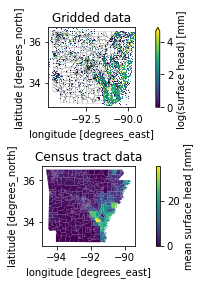

In [74]:
# set up and plot
dll.sfcheadsubrt.attrs['long_name'] = 'log(surface head)'
print(dll)
f, (ax1, ax2) = plt.subplots(2,1)
np.log(dll.sfcheadsubrt).plot(ax=ax1,robust=True,label='d')
ar_shp.plot(facecolor='none',edgecolor="black",linewidth=.1,ax=ax1)
ar_shp.plot('avgdepth',ax=ax2,legend=True,legend_kwds={'label':'mean surface head [mm]'})
#ar_shp.plot('avgdepth',ax=ax2,legend=True,legend_kwds={'shrink': 0.55})
ax1.title.set_text('Gridded data')
ax2.axes.set_xlabel('longitude [degrees_east]')
ax2.axes.set_ylabel('latitude [degrees_north]')
ax2.title.set_text('Census tract data')
#ax1.axes.set_aspect('equal')
#ax1.legend(fontsize=6)
#plt.legend(loc=1,prop={'size': 6})
#f.colorbar(ax2,shrink=0.9)
f.tight_layout()
plt.draw()